In [8]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rapidfuzz.distance import Levenshtein

import numpy as np

In [3]:
def author_overlap(a, b):
    if not a or not b:
        return 0.0
    return len(set(a) & set(b)) / max(len(set(a)), 1)

In [4]:
ROOTS = [
    "../clean-data/manual",
    "../clean-data/non-manual"
]

rows = []

for ROOT in ROOTS:
    for paper_id in os.listdir(ROOT):
        paper_dir = os.path.join(ROOT, paper_id)
        if not os.path.isdir(paper_dir):
            continue

        label_path = os.path.join(paper_dir, "label.json")
        if not os.path.exists(label_path):
            continue

        try:
            parsed = json.load(open(os.path.join(paper_dir, "parsed_reference.json"), encoding="utf-8"))
            crawled = json.load(open(os.path.join(paper_dir, "crawled_reference.json"), encoding="utf-8"))
            labels = json.load(open(label_path, encoding="utf-8"))
        except:
            continue

        for bib_key, arxiv_id in labels.items():
            if bib_key not in parsed or arxiv_id not in crawled:
                continue

            ref = parsed[bib_key]
            paper = crawled[arxiv_id]

            ref_title = ref["title"]
            paper_title = paper["title"]

            # ---- TF-IDF cosine (giữ nguyên) ----
            tfidf = TfidfVectorizer(stop_words="english")
            X = tfidf.fit_transform([ref["title"], paper["title"]])
            title_cosine = cosine_similarity(X[0:1], X[1:2])[0][0]

            rows.append({
                "paper_id": paper_id,
                "bib_key": bib_key,
                "arxiv_id": arxiv_id,

                # ===== embedding-based =====
                "title_tfidf_cosine": title_cosine,

                # ===== string matching =====
                "title_exact_match": int(ref_title == paper_title),

                # ===== metadata =====
                "year_abs_diff": abs((ref["year"] or 0) - (paper["year"] or 0)),
                "author_overlap_ratio": author_overlap(
                    ref["authors"], paper["authors"]
                )
            })

df = pd.DataFrame(rows)
df.head()


,paper_id,bib_key,arxiv_id,title_tfidf_cosine,title_exact_match,year_abs_diff,author_overlap_ratio
0,2212-11481,zhang2018monge,1809.10188,0.580333,0,0,1.0
1,2212-11481,e2019barron,1906.08039,0.611846,0,0,1.0
2,2212-11481,e2019machine,1912.12777,1.000000,1,0,1.0
3,2212-11481,e2020kolmogorov,2005.10807,1.000000,1,0,1.0
4,2212-11481,e2019min,1912.06987,0.550780,0,0,1.0


In [5]:
df.describe()

,title_tfidf_cosine,title_exact_match,year_abs_diff,author_overlap_ratio
count,29423.000000,29423.000000,29423.000000,29423.000000
mean,0.979087,0.907963,5.161132,0.922165
std,0.100011,0.289083,97.653232,0.146836
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.857143
50%,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,2023.000000,1.000000


<Axes: >

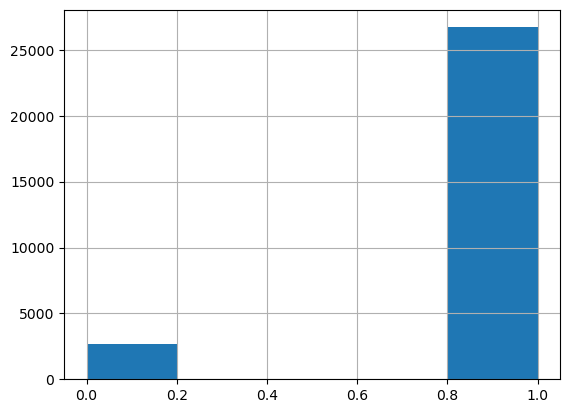

In [7]:
df["title_exact_match"].hist(bins=5)

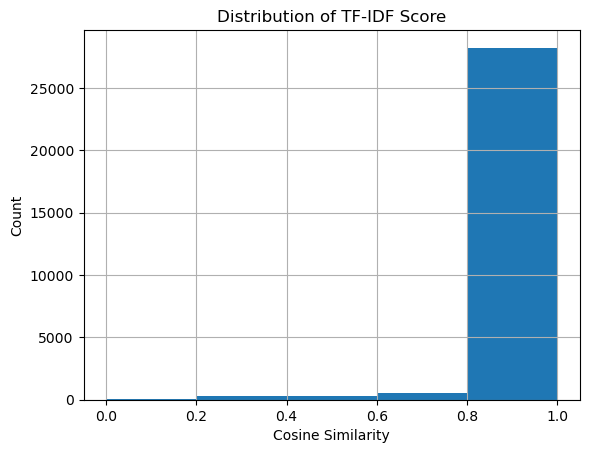

In [11]:
df["title_tfidf_cosine"].hist(bins=5)
plt.title("Distribution of TF-IDF Score")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

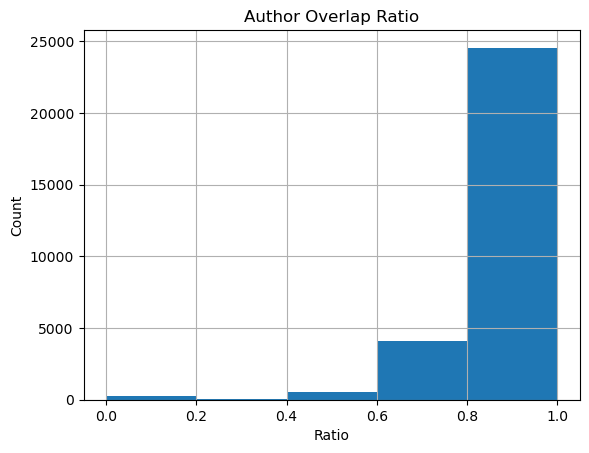

In [13]:
df["author_overlap_ratio"].hist(bins=5)
plt.title("Author Overlap Ratio")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.show()